# Import Library

In [1]:
from IPython.display import display
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import os

# Prepare Data

In [2]:

file_name = "preprocessed_kindle_review .csv"
file_path = os.path.abspath(file_name)

print(f"Đường dẫn file:\n{file_path}\n")

# Đọc CSV
df = pd.read_csv(file_path, sep="\t", on_bad_lines="skip")

df = pd.read_csv(file_path, sep=",", on_bad_lines="skip")

df.head()


Đường dẫn file:
C:\Users\ASUS\projects\review-data\preprocessed_kindle_review .csv



,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12000 non-null  int64 
 1   rating      12000 non-null  int64 
 2   reviewText  12000 non-null  object
 3   summary     11998 non-null  object
dtypes: int64(2), object(2)
memory usage: 375.1+ KB


In [4]:
df.isnull().sum()

Unnamed: 0    0
rating        0
reviewText    0
summary       2
dtype: int64

In [5]:
df['rating'].value_counts()

rating
5    3000
4    3000
1    2000
3    2000
2    2000
Name: count, dtype: int64

# Clean Data

# Delete Unneccesary Column

In [6]:
data = df[['rating', 'reviewText', 'summary']]

data.head()

,rating,reviewText,summary
0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,5,"This isn't the kind of book I normally read, a...",Great Story!


# Delete Null

In [7]:
processed_data = data.dropna()

processed_data.isnull().sum()

rating        0
reviewText    0
summary       0
dtype: int64

# Process Data for Training

# Clean Text

In [8]:
stop_words = set(stopwords.words('english'))

def clean_text(text: str) -> str:
    # 1. Bỏ ký tự đặc biệt, giữ chữ và số
    text = re.sub(r'[^a-zA-Z0-9\s-]+', ' ', text)
    
    # 2. Bỏ link
    text = re.sub(r'http\S+', '', text)
    
    # 3. Xóa HTML tags
    text = BeautifulSoup(text, "lxml").get_text()
    
    # 4. Tách từ, bỏ stopwords
    tokens = [word for word in text.split() if word.lower() not in stop_words]
    
    # 5. Bỏ khoảng trắng thừa
    return " ".join(tokens)

processed_data.loc[:, "reviewText"] = processed_data["reviewText"].astype(str).apply(clean_text)
processed_data.loc[:,"summary"] = processed_data["summary"].astype(str).apply(clean_text)
    

In [9]:
processed_data.head()

,rating,reviewText,summary
0,5,book first bookmobile book bought school book ...,50 years ago
1,1,read description book wait read downloaded Kin...,Boring Boring Boring
2,5,edit review book believe got right updated re-...,Wiggleliscious new toy ready
3,5,normally buy mystery novels like However time ...,good read
4,5,kind book normally read although try limit cer...,Great Story


In [10]:
wl=WordNetLemmatizer()

def lemmatize_words(text):
    return " ".join([wl.lemmatize(word) for word in text.split()])

processed_data.loc[:, 'reviewText'] = processed_data['reviewText'].apply(lemmatize_words)
processed_data.loc[:,"summary"] = processed_data["summary"].astype(str).apply(clean_text)

In [11]:
processed_data.loc[:,'rating']=processed_data['rating'].apply(lambda x:0 if x<3 else 1 )

In [12]:
processed_data = pd.concat([
    processed_data[["rating", "reviewText"]].rename(columns={"reviewText": "text"}),
    processed_data[["rating", "summary"]].rename(columns={"summary": "text"})
], ignore_index=True)

In [13]:
processed_data.head()

,rating,text
0,1,book first bookmobile book bought school book ...
1,0,read description book wait read downloaded Kin...
2,1,edit review book believe got right updated re-...
3,1,normally buy mystery novel like However time d...
4,1,kind book normally read although try limit cer...


In [14]:
processed_data['rating'].value_counts()

rating
1    15996
0     8000
Name: count, dtype: int64

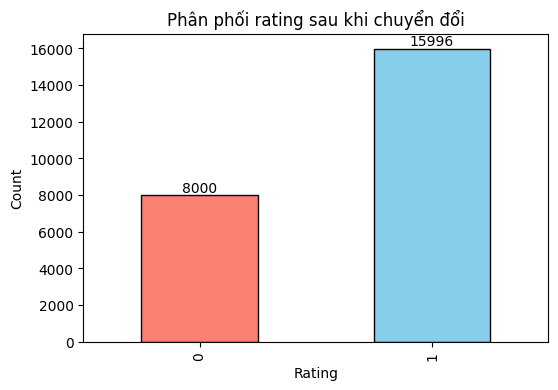

In [15]:
binary_counts = processed_data["rating"].value_counts().sort_index()

ax = binary_counts.plot(
    kind="bar",
    color=["salmon", "skyblue"],
    edgecolor="black",
    figsize=(6,4),
    title="Phân phối rating sau khi chuyển đổi"
)

ax.set_xlabel("Rating")
ax.set_ylabel("Count")

for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha="center", va="bottom", fontsize=10)

plt.show()


# BOW + TFIDF

In [16]:
X_train,X_test,y_train,y_test=train_test_split(processed_data['text'],processed_data['rating'],test_size=0.20)

In [17]:
X_train

9281     first book series prequel required whole nuthe...
13245                   Credible heroine thick-headed hero
20314                                     Outstanding read
8589     Nothing better start reading novel sudden real...
16970                                                  Sjm
                               ...                        
8132     Cloning Jesus Christ seems like good place sta...
21087                        103 pages never went anywhere
6314     big fan novella one good course want usually g...
6192     Really liked story hard time keeping track cha...
13568                                          Book review
Name: text, Length: 19196, dtype: object

In [18]:

vectorizer_bow = CountVectorizer()
X_train_bow=vectorizer_bow.fit_transform(X_train).toarray()
X_test_bow=vectorizer_bow .transform(X_test).toarray()

In [19]:
tfidf=TfidfVectorizer()
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)

In [20]:

nb_model_bow = MultinomialNB().fit(X_train_bow, y_train)
nb_model_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)

In [21]:
y_pred_bow=nb_model_bow.predict(X_test_bow)

In [22]:
y_pred_tfidf=nb_model_tfidf.predict(X_test_tfidf)

In [23]:
print("BOW accuracy:",accuracy_score(y_test,y_pred_bow))

BOW accuracy: 0.8095833333333333


In [24]:
print("TfIdf accuracy:",accuracy_score(y_test,y_pred_tfidf))

TfIdf accuracy: 0.7602083333333334


In [25]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2') 
X_train_vec = model.encode(X_train.tolist(), convert_to_tensor=True)
X_test_vec = model.encode(X_test.tolist(), convert_to_tensor=True)

C:\Users\ASUS\anaconda3\envs\pyspark-env\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [26]:
clf = SVC(kernel='linear')
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66      1571
           1       0.83      0.87      0.85      3229

    accuracy                           0.79      4800
   macro avg       0.76      0.75      0.75      4800
weighted avg       0.79      0.79      0.79      4800

Accuracy: 0.79


# Stored Model

In [27]:
import pickle

with open("nb_model_bow.pkl", "wb") as f:
    pickle.dump(nb_model_bow, f)

with open("vectorizer_bow.pkl", "wb") as f:
    pickle.dump(vectorizer_bow, f)


# Create 1 enpoint for server

In [1]:
from flask import Flask, request, jsonify
import pickle

app = Flask(__name__)

@app.route("/", methods=["GET"])
def home():
    return jsonify({"message": "API is running "})

# Endpoint dự đoán từ comment của frontend
@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()

    # Lấy comment từ frontend
    comment = data.get("comment")
    model_type = data.get("model_type", "bow")  # mặc định là bow

    if not comment:
        return jsonify({"error": "Comment is required"}), 400

    # Chọn model
    if model_type == "bow":
        vec = vectorizer_bow.transform([comment])
        prediction = nb_model_bow.predict(vec)[0]
    else:
        vec = vectorizer_tfidf.transform([comment])
        prediction = nb_model_tfidf.predict(vec)[0]

    return jsonify({
        "comment": comment,
        "model_type": model_type,
        "prediction": int(prediction)  # có thể là 0 = negative, 1 = positive
    })

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.31.21:5000
Press CTRL+C to quit
[2025-10-09 14:50:20,279] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\envs\pyspark-env\lib\site-packages\flask\app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\ASUS\anaconda3\envs\pyspark-env\lib\site-packages\flask\app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\ASUS\anaconda3\envs\pyspark-env\lib\site-packages\flask\app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\ASUS\anaconda3\envs\pyspark-env\lib\site-packages\flask\app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_659020\803226314.py", line 24, in p

: 